In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [6, 4]


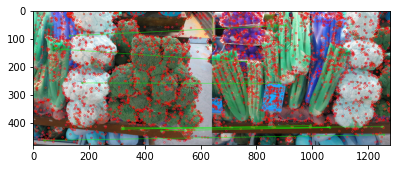

(<matplotlib.image.AxesImage at 0x1f2a31bca60>, None)

In [3]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]
img1 = cv2.imread('./SYS809_projet2021_sequences1/legumesA-00.jpg')
img2 = cv2.imread('./SYS809_projet2021_sequences1/legumesA-01.jpg')
gray_img1 = cv2.imread('./SYS809_projet2021_sequences1/legumesA-00.jpg' , cv2.IMREAD_GRAYSCALE) 
gray_img2 = cv2.imread('./SYS809_projet2021_sequences1/legumesA-01.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(gray_img1)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
#Le champ .pt des object KeyPoint contiennent la position du point-cle

img1=cv2.drawKeypoints(img1,kp1,None)
img2=cv2.drawKeypoints(img2,kp2,None)
cv2.imwrite('./images_et_fichier/sift_keypoints1.jpg',img1)
cv2.imwrite('./images_et_fichier/sift_keypoints2.jpg',img2)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

#knnMatch retourne les 2 plus proche voisin pour chaque membre de des1
matches = flann.knnMatch(des1,des2,k=2)
#Les objects DMatch contiennent index de du point-cle de ds1 match dans le champ queryIdx
#et l'index du point-cle appartenant a des2 dans le champ trainIdx

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]


# ratio test as per Lowe's paper,
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

In [4]:
import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
tf.__version__
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14023920915985706229
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17203323931917646734
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2b:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import os
import cv2
import numpy as np
#https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
   
def load_img(img_path,img_shape):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path , target_size=(img_rows, img_cols))    
    img = image.img_to_array(img) 
    img = np.expand_dims(img, axis=0)

    img =  preprocess_input(img)


    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return img

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16


model = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


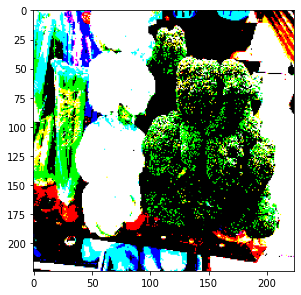

In [7]:
from tensorflow.keras import backend as K

get_layer_output = K.function([model.input], [model.layers[-2].output])

data_path='./SYS809_projet2021_sequences1/legumesA-00.jpg'
img_shape=[224,224]
img = load_img(data_path,img_shape)

plt.imshow(img[0])




In [8]:
#print(model.summary())
print(img.shape)

(1, 224, 224, 3)


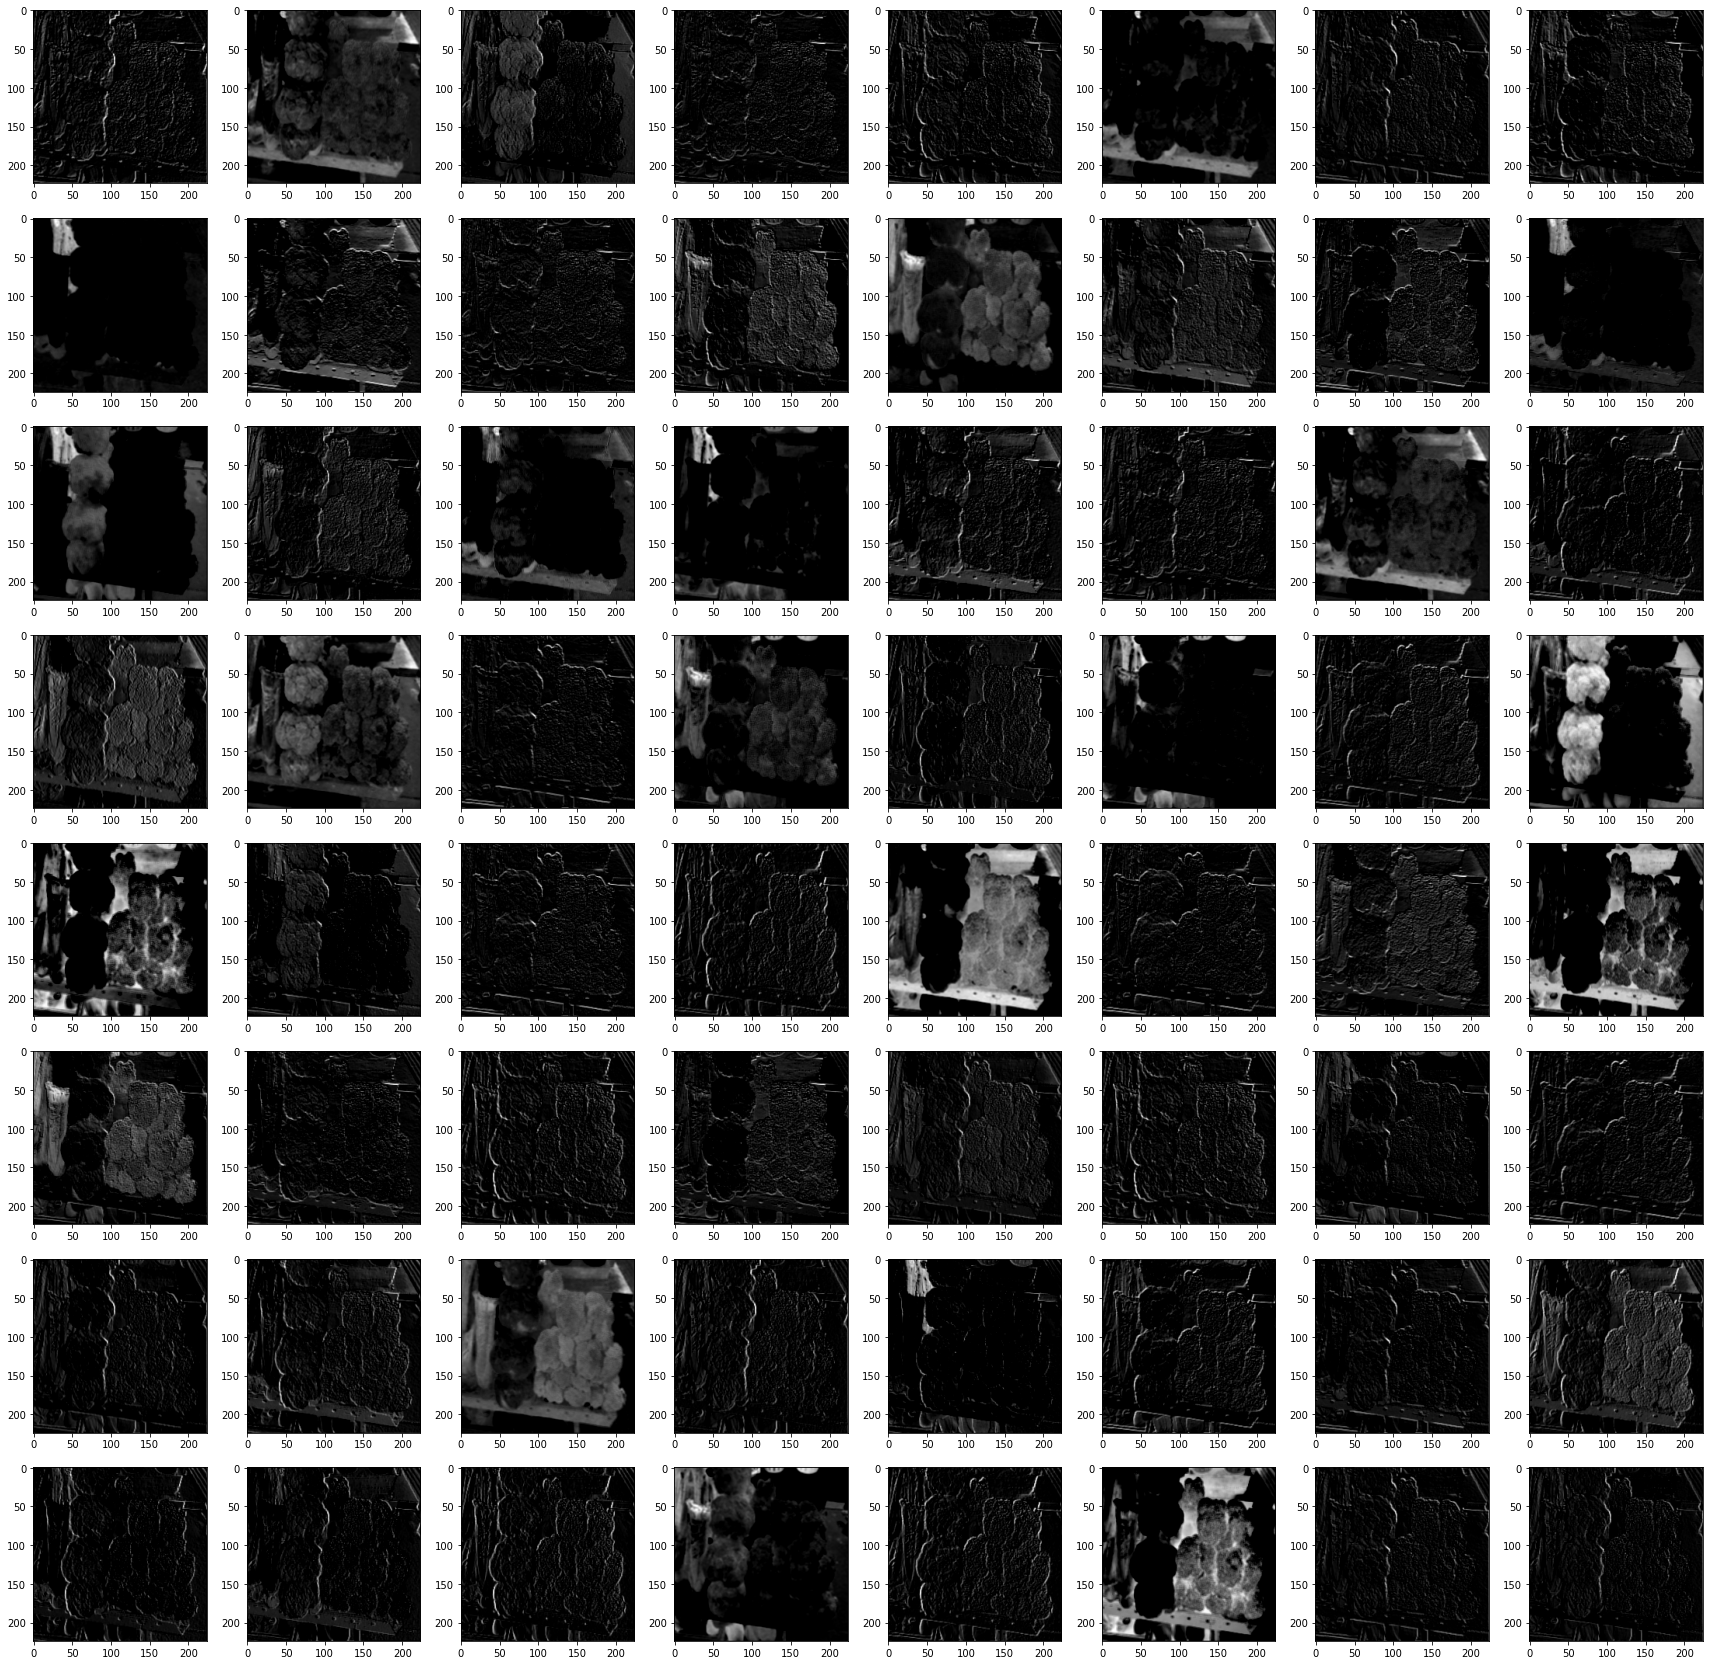

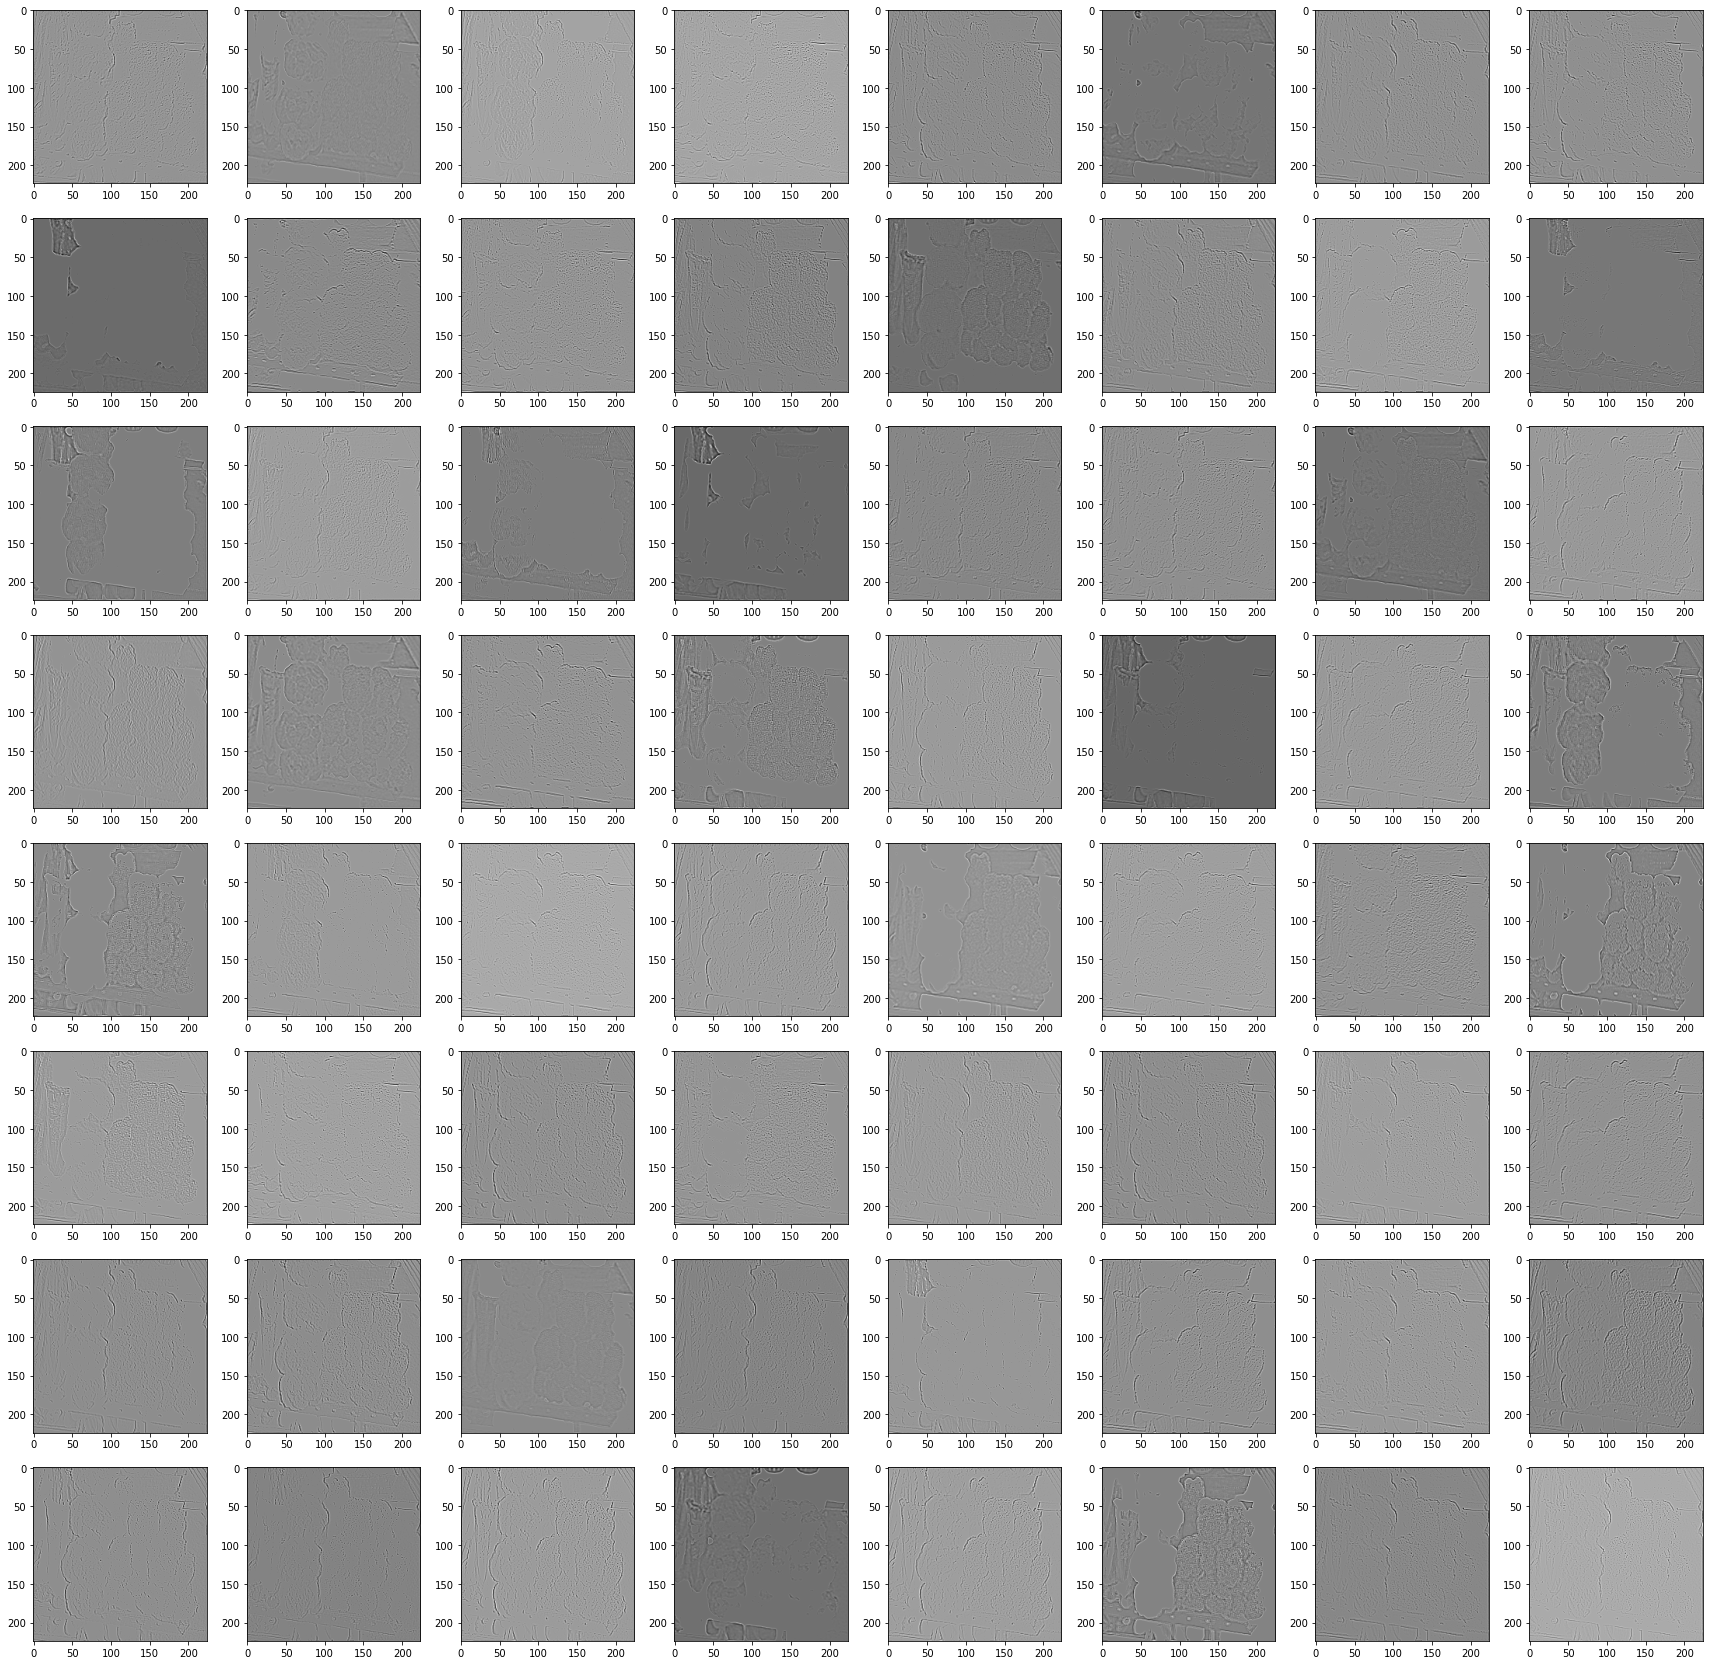

[[ 44 180]] 7642.987
[[ 1458.5319   -3745.948    -2636.5012   ...  1023.82825   3234.437
   -578.90814 ]
 [-2618.8408    3227.0837    -220.23456  ... -4105.5156   -2709.423
   2693.1084  ]
 [-2392.3667    1161.1743    1161.4706   ...  4670.7925   -4201.6646
   3742.9656  ]
 ...
 [ 1309.4989   -1792.6956   -1188.0126   ...    10.517471  1132.131
  -2056.5806  ]
 [ 1059.4379   -1893.7249   -1863.8038   ...   788.0602    1776.5189
  -2301.7202  ]
 [  698.44244   2074.0166    2747.2197   ... -1401.0767   -1598.9237
    387.8828  ]]


"fig3 = plt.figure(figsize=(30, 30))\nfor i in range(1, columns*rows + 1):\n    out = laps[i-1]\n    #print(out.shape)\n    #plt.imshow(layer_out[0][:,:,2])\n    #img_gray = cv2.cvtColor(layer_out[0][:,:,i-1], cv2.COLOR_BGR2GRAY)\n    dst = laplace(out)\n    #out = \n\n    fig3.add_subplot(rows, columns, i)\n    plt.imshow(dst, cmap=plt.get_cmap('gray'))\nplt.show()"

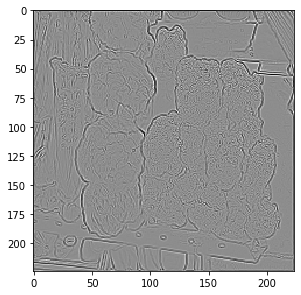

In [33]:
from scipy.ndimage import laplace

'''for i, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        print(i)
        get_layer_output = K.function([model.input], layer.output)
        layer_out = np.array(get_layer_output(img))

        #plt.figure()
        plt.imshow(layer_out[0][:,:,1])'''

ddepth = cv2.CV_8U  
kernel_size = 3

fig = plt.figure(figsize=(30, 30))

columns = 8
rows = 8

imgs = []
get_layer_output = K.function([model.input], model.layers[1].output)
layer_out = np.array(get_layer_output(img))
for i in range(1, columns*rows + 1):
    #plt.imshow(layer_out[0][:,:,2])
    fig.add_subplot(rows, columns, i)
    imgs.append(layer_out[0][:,:,i-1])
    plt.imshow(imgs[-1], cmap=plt.get_cmap('gray'))
plt.show()

laps = []
fig2 = plt.figure(figsize=(30, 30))
for i in range(1, columns*rows + 1):
    out = imgs[i-1]
    #print(out.shape)
    #plt.imshow(layer_out[0][:,:,2])
    #img_gray = cv2.cvtColor(layer_out[0][:,:,i-1], cv2.COLOR_BGR2GRAY)
    dst = cv2.Laplacian(out, cv2.CV_32F )
    laps.append(dst)
    fig2.add_subplot(rows, columns, i)
    plt.imshow(laps[-1], cmap=plt.get_cmap('gray'))
plt.show()

fig3 = plt.figure()
#mag = np.linalg.norm(laps, axis = 0)
mag = np.sum(laps, axis = 0)
#mag /= mag.max()/255.0
plt.imshow(mag, cmap=plt.get_cmap('gray'), interpolation='nearest')


d_i = np.argwhere(mag == np.amax(mag)) 
print(d_i, np.amax(mag))
print(mag)

'''fig3 = plt.figure(figsize=(30, 30))
for i in range(1, columns*rows + 1):
    out = laps[i-1]
    #print(out.shape)
    #plt.imshow(layer_out[0][:,:,2])
    #img_gray = cv2.cvtColor(layer_out[0][:,:,i-1], cv2.COLOR_BGR2GRAY)
    dst = laplace(out)
    #out = 

    fig3.add_subplot(rows, columns, i)
    plt.imshow(dst, cmap=plt.get_cmap('gray'))
plt.show()'''



In [10]:
def local_arg_exrtrema(mat):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat.shape[0]-1):
        for j in range(1, mat.shape[1]-1):
            pos = np.argwhere(mat[i-1:i+2, j-1:j+2] == np.amax([mat[i, j] , 
                                            mat[i+1, j],
                                            mat[i-1, j],
                                            mat[i+1, j+1],
                                            mat[i+1, j-1],
                                            mat[i-1, j+1],
                                            mat[i-1, j-1],
                                            mat[i, j+1],
                                            mat[i, j-1]]))
            idx.append(np.array([i-1,j-1]) + pos)

    return np.unique(idx, axis=0)


In [11]:
test_array = np.array([[ 90,  1,  2,  3,  4],
                       [ 7,  50,  9, 10, 11],
                       [14,  15,   1, 600, 18],
                       [21, 22, 23, 1, 25],
                       [28, 29, 30, 31, 6]])

local_argmax(mag)

array([[[  0,   1]],

       [[  0,   2]],

       [[  0,   5]],

       ...,

       [[223, 218]],

       [[223, 219]],

       [[223, 222]]], dtype=int64)

In [12]:
model.layers[1].name


'block1_conv1'

In [57]:
# A function that does the above step but for any all layers in a block

def cnn_lap(image, layer_name):
    layers = [l for l in model.layers if layer_name == l.name]
    print(layers)
    mag = []
    for layer in layers:
        if type(layer.output_shape) is list:
            print(layer.output_shape)
            num_channels = layer.output_shape[0][-1]
        else:
            num_channels = layer.output_shape[-1]
        print(num_channels)

        imgs = []
        get_layer_output = K.function([model.input], layer.output)
        layer_out = np.array(get_layer_output(image))
        for i in range(0, num_channels):
            #plt.imshow(layer_out[0][:,:,2])
            imgs.append(layer_out[0][:,:,i])

        laps = []
        for i in range(0, num_channels):
            out = imgs[i]
            dst = cv2.Laplacian(out, cv2.CV_32F )
            laps.append(dst)

        #mag.append(np.linalg.norm(np.abs(laps), axis = 0))
        mag.append(np.sum(laps, axis = 0))
        #mag /= mag.max()/255.0
    return mag[0]


In [14]:
model.layers[1].output_shape[-1]

64

input_1
[(None, 224, 224, 3)]
3
block1_conv1
64
block1_conv2
64
block1_pool
64
block2_conv1
128
block2_conv2
128
block2_pool
128
block3_conv1
256
block3_conv2
256
block3_conv3
256
block3_pool
256
block4_conv1
512
block4_conv2
512
block4_conv3
512
block4_pool
512
block5_conv1
512
block5_conv2
512
block5_conv3
512
block5_pool
512


"mag_input = cnn_lap(img, block=2)\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\n\nax1.imshow(mag[0], cmap=plt.get_cmap('gray'))\nax2.imshow(mag[1], cmap=plt.get_cmap('gray'))\nax3.imshow(np.abs(mag[1]-mag[0]), cmap=plt.get_cmap('gray'))"

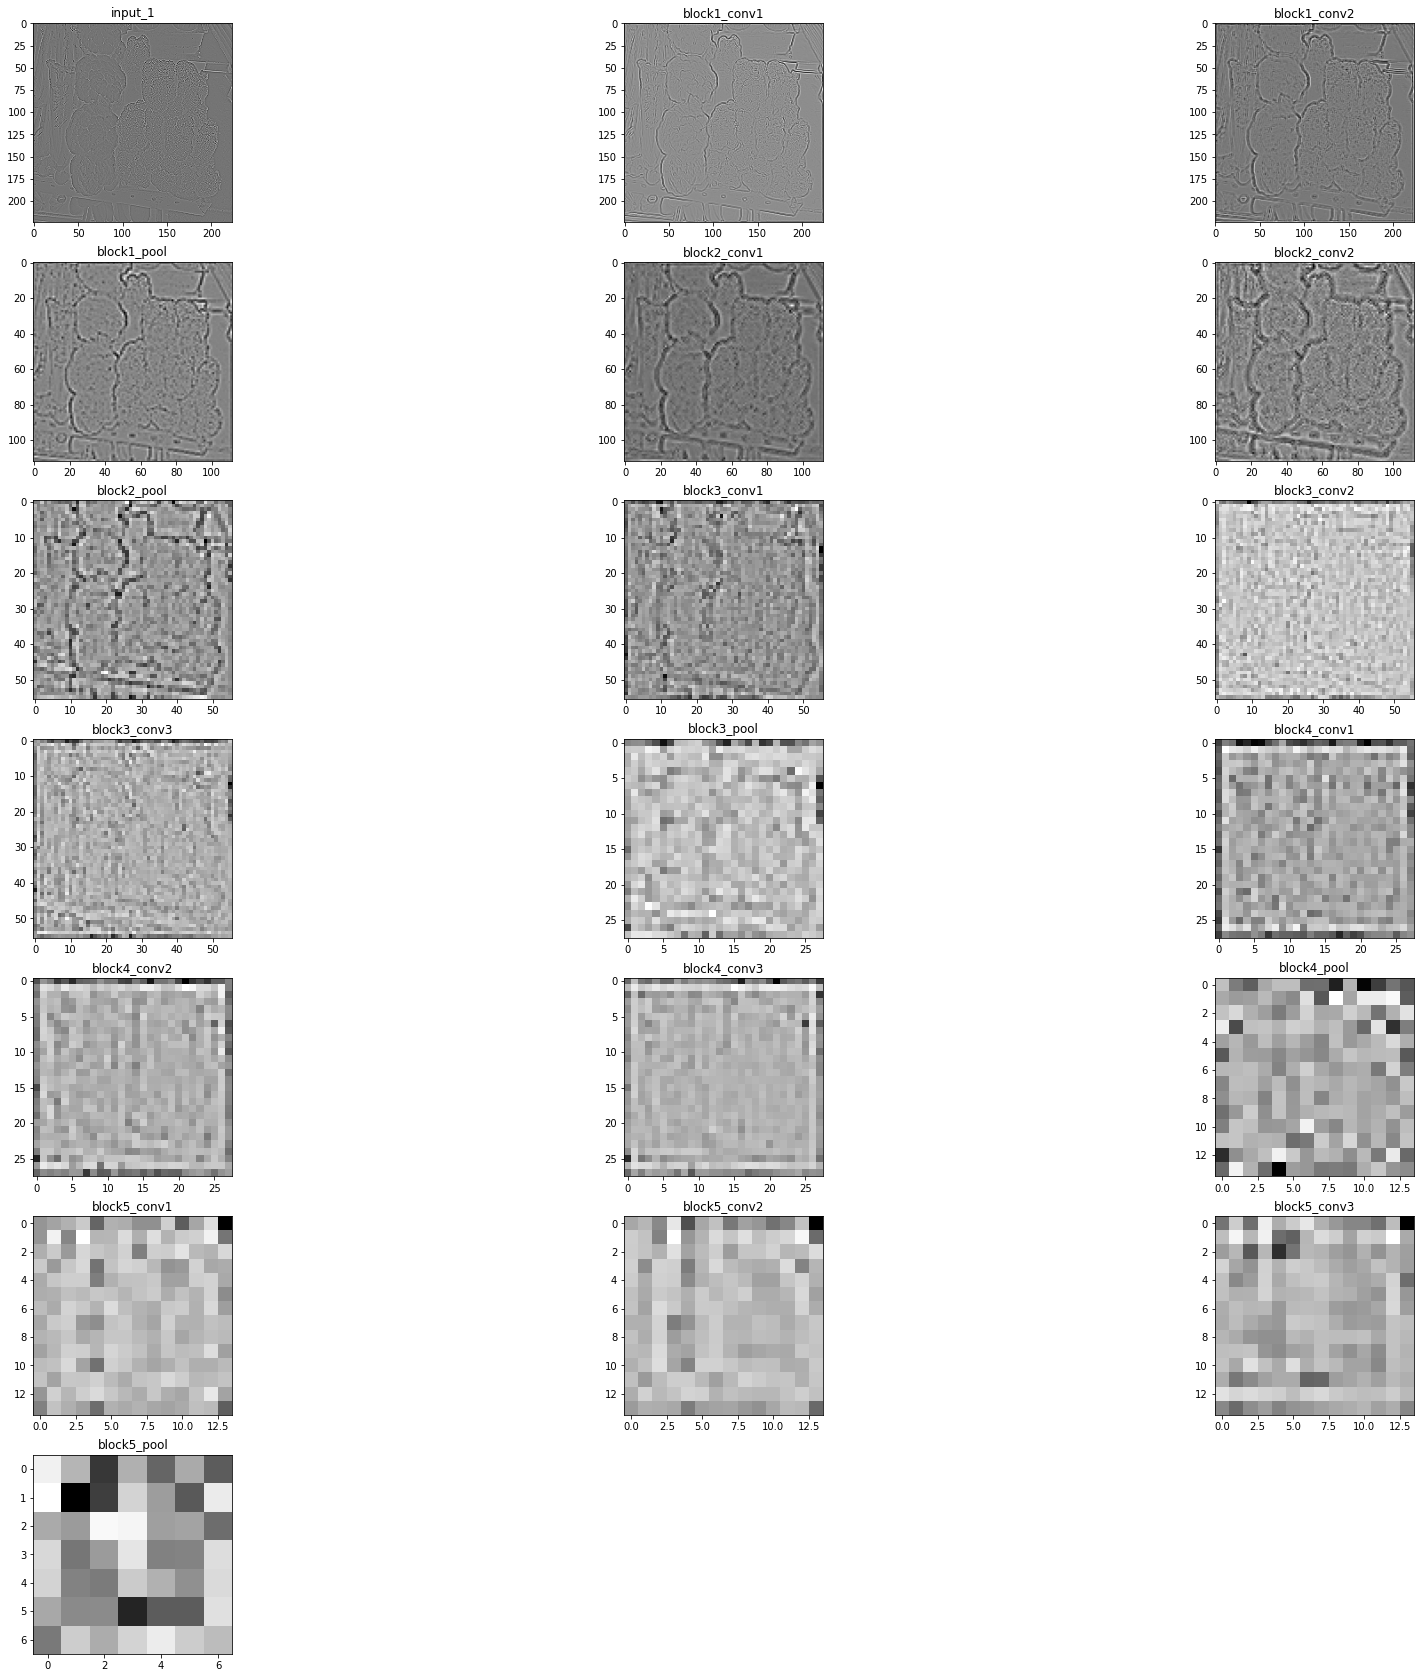

In [62]:
layers = [l.name for l in model.layers if ('conv' in l.name)]

#plt.subplots(len(layers)/3, 3)

fig = plt.figure(figsize=(30, 30))
for i, layer in enumerate(layers):
    print(layer)
    fig.add_subplot(int(np.ceil(len(layers)/3)), 3, i+1)
    mag_input = cnn_lap(img, layer_name=layer)
    plt.imshow(mag_input, cmap=plt.get_cmap('gray'))
    plt.title(layer)

'''mag_input = cnn_lap(img, block=2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(mag[0], cmap=plt.get_cmap('gray'))
ax2.imshow(mag[1], cmap=plt.get_cmap('gray'))
ax3.imshow(np.abs(mag[1]-mag[0]), cmap=plt.get_cmap('gray'))'''

#ax3.imshow(mag[2], cmap=plt.get_cmap('gray'))



In [ ]:
local_argmax(mag[1])

array([[[  0,   2]],

       [[  0,   3]],

       [[  0,   9]],

       ...,

       [[111, 106]],

       [[111, 107]],

       [[111, 110]]], dtype=int64)

In [28]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     